# **Projet 6 : Classifiez automatiquement des biens de consommation**

# Notebook 2 : Analyse des données visuelles (Images)

# Sommaire:

**Objectif**

**<a href="#C1"> I) Fonctions de l'analyse (Clustering et Réduction de dimensions) </a>**


**<a href="#C2"> II) Chargement et aperçu des images</a>**

    
**<a href="#C3"> III) Creation de features et Clustering</a>**
- <a href="#C4"> 1) SIFT</a>
- <a href="#C5"> 2) VGG16 </a>
- <a href="#C6"> 3) VGG19 </a>
- <a href="#C7"> 4) Xception </a>
- <a href="#C8"> 5) Inception V3</a>
- <a href="#C9"> 6) Resnet</a>

**<a href="#C10">IV) Analyse du meilleur modèle</a>**

&nbsp;

***

# **Objectif**

**Contexte :**

L’ entreprise "Place de marché” souhaite lancer une marketplace e-commerce. Pour cela, les vendeurs doivent attribuer une catégorie manuellement à leurs produits à partir d’une description et d’une photo.  Afin de passer à une plus large échelle et faciliter le processus, il devient nécessaire d’automatiser cette tâche.
  
_


**Mission :** 

Réaliser une première étude de faisabilité d'un moteur de classification afin d'attribuer automatiquement la catégorie à un article :
- Analyse de données textuelles (description) + Clustering
- Analyse de données visuelles (image) + Clustering
&nbsp;

_


**Données :**

Export de la base de données contenant 1050 produits, leur description et leur image associées
&nbsp;

_


**Livrables :**

Afin de répondre à cette mission, trois notebook ont été réalisé : 
- Notebook 1 : Analyse des données textuelles (description) et clusterisation
- Notebook 2 : Analyse des données visuelles (images) et clusterisation
- Notebook 3 : Combinaison du meilleur modèle de texte et d'image et classification supervisée

***

In [4]:
# Import des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [5]:
# Import du DF déjà clean

df = pd.read_csv(r"C:\Users\elodi\Documents\DS\Nouveau dossier\data_cleaned.csv")

# <a name="C1"> I) Fonctions de l'analyse (Clustering et Réduction de dimensions)</a>

In [7]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.preprocessing import LabelEncoder


def select_n_components(features, goal_var: float) -> int:
    """ 
    La méthode PCA de sklearn permet de selectionner un float en n_compoents afin de ne garder que 0.99 (par ex) de la variance totale mais cela n'est pas possible pour la méthode SVD.
    Cette function permet de récupérer le nombre de composantes expliquant X%  de la variance totale par la méthode de réduction SVD. 
    """

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components

##########################################
##########################################

# Calcul Reduction, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters


def reduction_fct(features, reduc='SVD'):
    """ Cette fonction permet de réduire et clusteriser des données 
    avec le choix de l'algorithme de réduction dans les arguments : SVD, UMAP ou TSNE
    """

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")

##########################################
##########################################


def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


##########################################
##########################################

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

# <a name="C2"> II) Chargement et aperçu des images</a>

In [9]:
# Chargement de la liste des images

from os import listdir

path = "C:\\Users\\elodi\\Documents\\DS\\Flipkart\\Images\\"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [10]:
#data_photo = pd.DataFrame(list_photos, columns = ['photo_id'])
# data_photo = pd.merge(df[['image','Categ_A']],data_photo,
#                      right_on='photo_id',
#                      left_on='image').drop(columns=['image'])

In [11]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["Categ_A"])

Home Decor & Festive Needs 


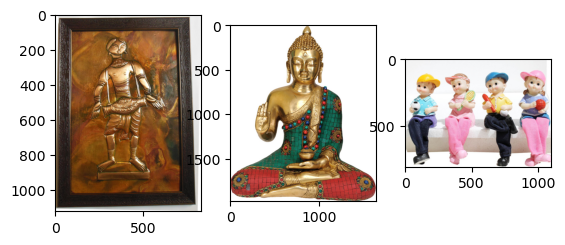

Beauty and Personal Care 


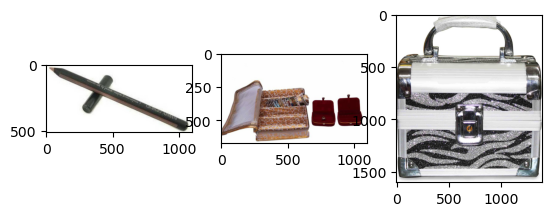

Baby Care 


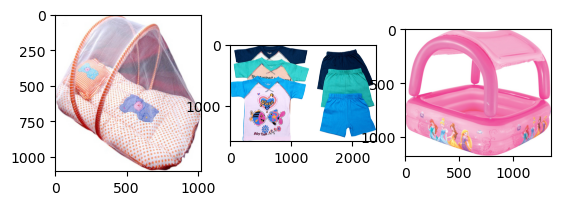

Computers 


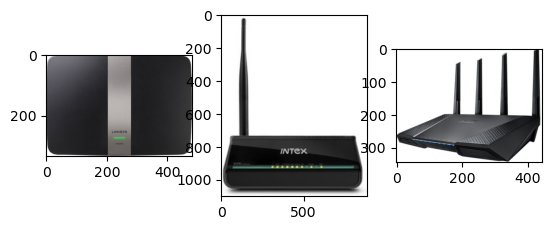

Watches 


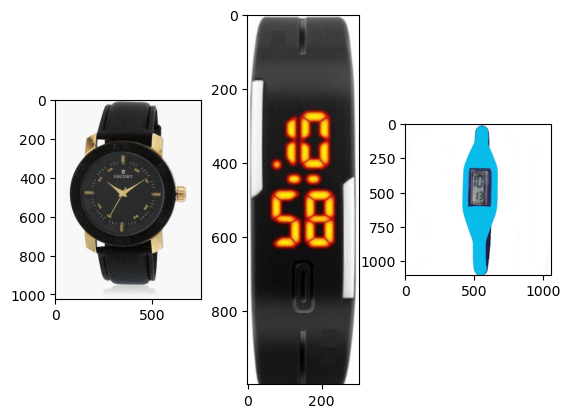

Kitchen & Dining 


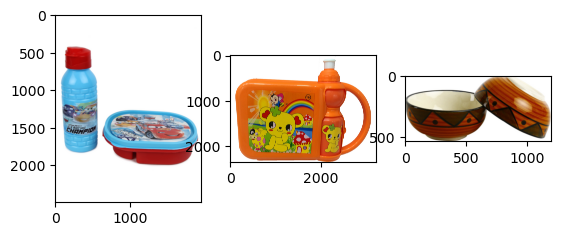

Home Furnishing 


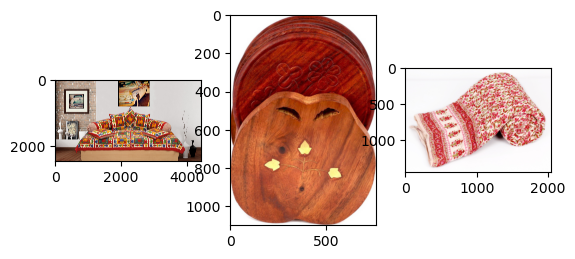

In [12]:
# Représentation d'un échantillons d'image par catégorie
from matplotlib.image import imread


def list_fct(name):
    list_image_name = [df["image"][i]
                       for i in range(len(df)) if df["Categ_A"][i] == name]
    return list_image_name


for categ in list(set(df['Categ_A'])):
    globals()[f'list_{categ}'] = [df["image"][i]
                                  for i in range(len(df)) if df["Categ_A"][i] == categ]

for name in list(set(df['Categ_A'])):
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [13]:
# Initialisation d'une liste vide pour les résultats d'ARI :

ARI_results = np.empty(shape=[0, 3])

# <a name="C3"> III) Creation de features et Clustering</a>

## <a name="C4"> 1) SIFT</a>

### a) Exemple de Descripteurs sur un article

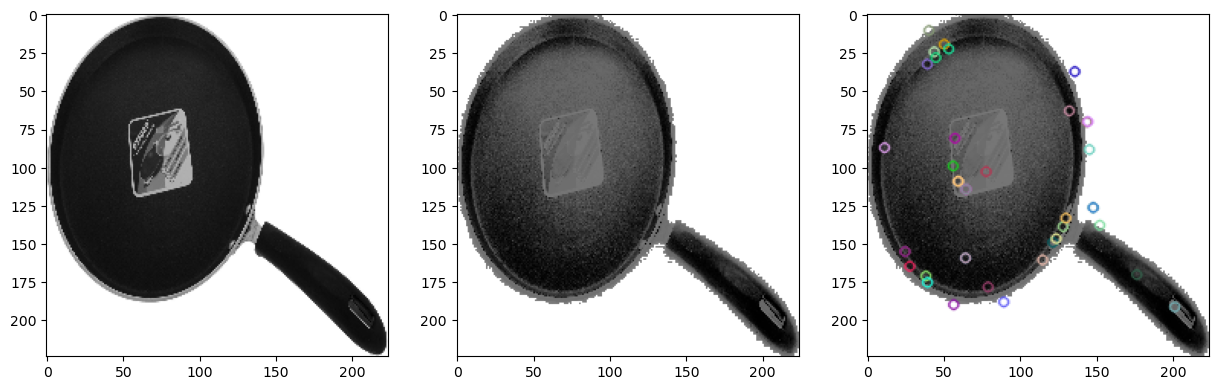

In [17]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()

image = cv2.imread(path+list_photos[1], 0)  # convert in gray
image = cv2.resize(image, (224, 224))
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(image, cmap='gray')


image = cv2.equalizeHist(image)   # equalize image histogram

plt.subplot(132)
plt.imshow(image, cmap='gray')

kp, des = sift.detectAndCompute(image, None)
image = cv2.drawKeypoints(image, kp, image)

plt.subplot(133)
plt.imshow(image, cmap='gray')
plt.show()

In [18]:
len(df["image"])

1050

### b) Création des descripteurs

In [20]:
import time
import cv2
from PIL import Image

import numpy as np
from tqdm import tqdm

# Création de l'objet SIFT
sift = cv2.SIFT_create()

sift_keypoints = []
temps1 = time.time()

for image_num in tqdm(range(len(df["image"]))):
    image = cv2.imread(path + df["image"][image_num], 0)  # Lecture en niveaux de gris
    image = cv2.resize(image, (299, 299))
    res = cv2.equalizeHist(image)  # Égalisation de l'histogramme
    
    # Extraction des keypoints et descripteurs
    _, des = sift.detectAndCompute(res, None)
    
    # Ajout uniquement si descripteurs existent
    if des is not None:
        sift_keypoints.append(des)

# Conversion en tableau et concaténation des descripteurs
sift_keypoints_by_img = np.array(sift_keypoints, dtype=object)  
sift_keypoints_all = np.vstack(sift_keypoints_by_img)  # Concaténation

print("\nNombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", f"{duration1:.2f} secondes")

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:24<00:00, 43.06it/s]



Nombre de descripteurs :  (550949, 128)
Temps de traitement SIFT descriptor :  24.46 secondes


### c) Clustering des descripteurs

In [22]:
# Création des clusters de descripteurs
#  Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables
from sklearn import cluster, metrics


# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  742
Création de 742 clusters de descripteurs ...
temps de traitement kmeans :             7.35 secondes


### d) Création des histogrammes

In [24]:
# Creation of histograms
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms (features)
temps1 = time.time()

hist_vectors = []

for i, image_desc in enumerate(tqdm(sift_keypoints_by_img)):
    #if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

100%|█████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:01<00:00, 557.29it/s]

temps de création histogrammes :             1.89 secondes


### e) Clustering

In [26]:
# kmeans

ARI, labels = kmeans_fct(im_features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["SIFT", "None", ARI]], axis=0)

ARI :  0.0505


In [27]:
# PCA + kmeans

from sklearn.decomposition import PCA
pca = PCA(n_components=.99, random_state=22)
pca.fit(im_features)
x = pca.transform(im_features)

print(f"Components before PCA: {im_features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["SIFT", "PCA", ARI]], axis=0)

Components before PCA: 742
Components after PCA: 555
ARI :  0.0373


ARI :  0.0498


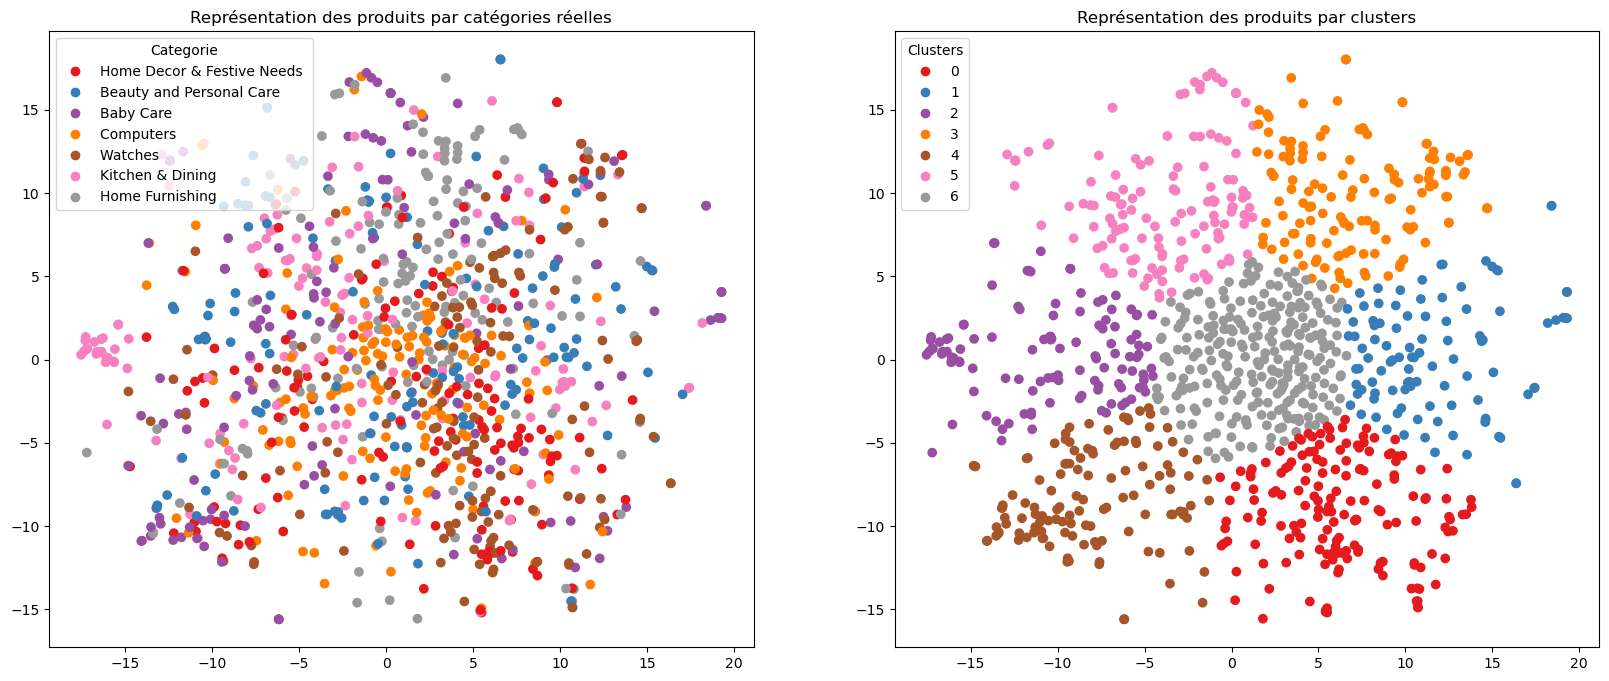

In [28]:
# TSNE + kmeans
X_reduc = reduction_fct(im_features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "TSNE", ARI]], axis=0)

ARI :  0.039


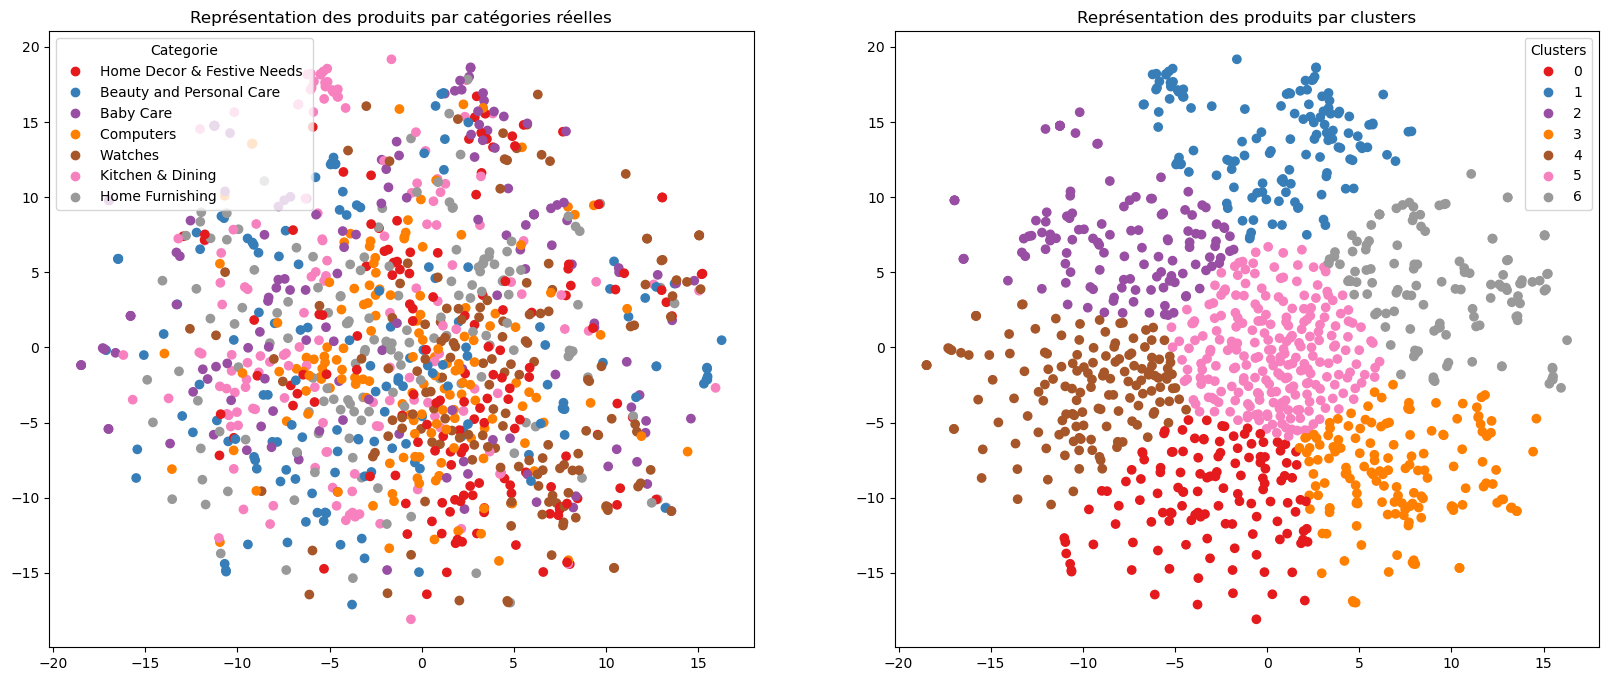

In [29]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["SIFT", "PCA-TSNE", ARI]], axis=0)

## <a name="C5"> 2) VGG16 </a>

In [31]:
# Présentation du modèle

from keras.applications import VGG16


VGG16_model = VGG16(
    include_top=True,
    weights="imagenet",
)

VGG16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Chargement des images et pre-processing spécifique

from keras.applications import vgg16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from PIL import Image, ImageOps
import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg16.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:20<00:00, 51.02it/s]


In [33]:
from keras.applications import VGG16
from keras.models import Model

# Charger le modèle VGG16 pré-entraîné
VGG16_model = VGG16()

# Modifier le modèle pour obtenir la sortie de la couche avant la dernière
VGG16_model = Model(inputs=VGG16_model.input, outputs=VGG16_model.layers[-2].output)

# Prédiction sur les données X
features = VGG16_model.predict(X, batch_size=32, verbose=1)  # Ajuster batch_size selon la RAM


33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step


In [34]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG16", "None", ARI]], axis=0)

ARI :  0.3786


In [35]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG16", "PCA", ARI]], axis=0)

Components before PCA: 4096
Components after PCA: 824
ARI :  0.378


ARI :  0.5056


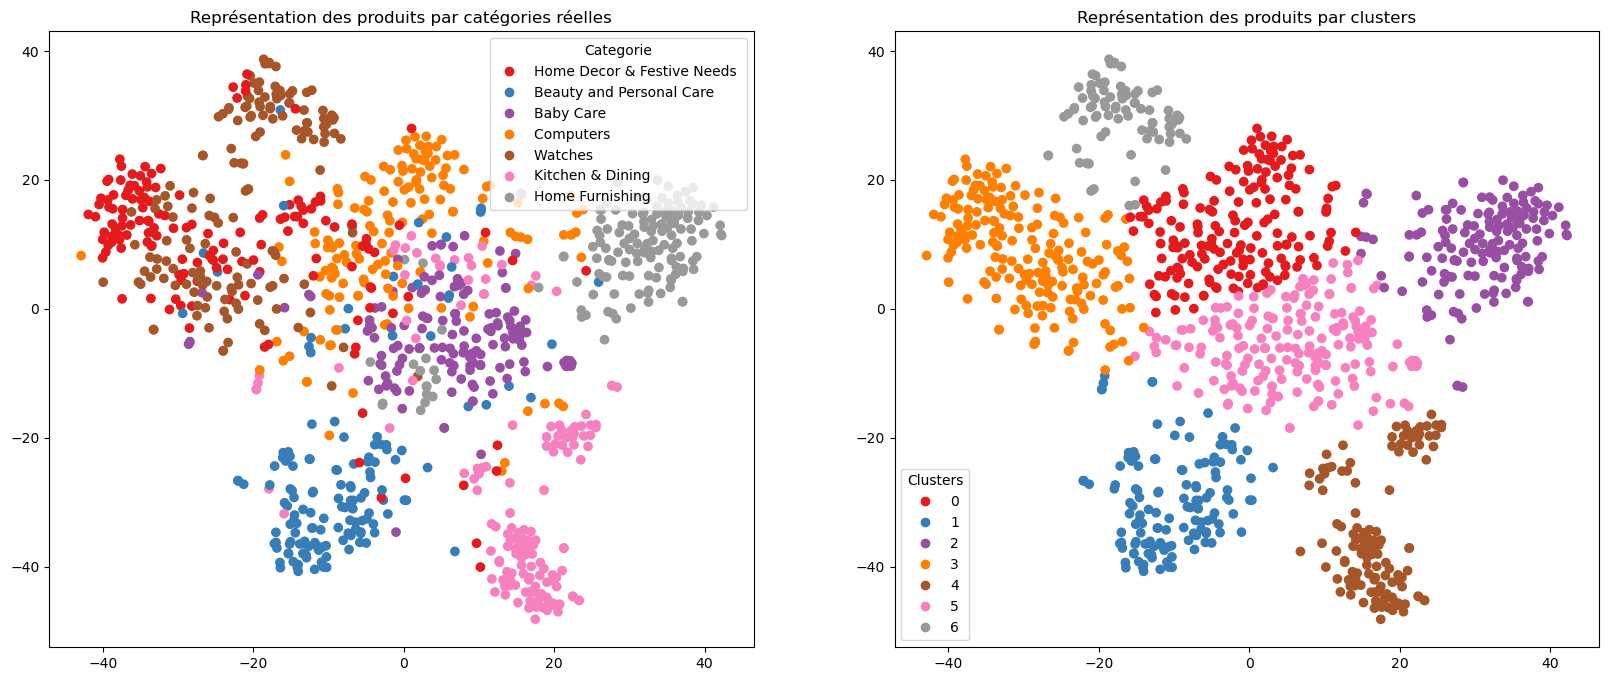

In [36]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG16", "TSNE", ARI]], axis=0)

ARI :  0.4945


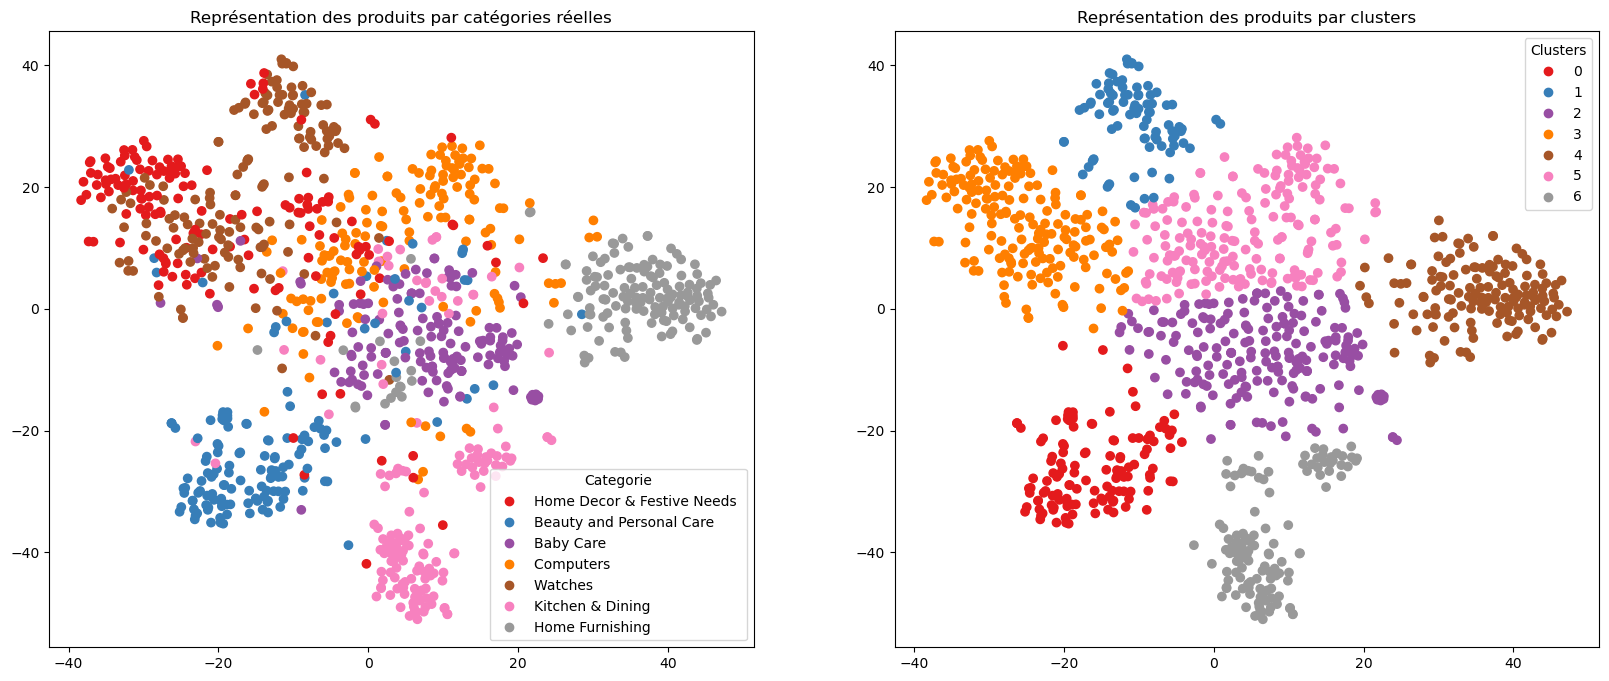

In [37]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG16", "PCA-TSNE", ARI]], axis=0)

## <a name="C6"> 3) VGG19</a>

In [39]:
# Présentation du modèle

from keras.applications import VGG19


VGG19_model = VGG19(
    include_top=True,
    weights="imagenet",
)

VGG19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Chargement des images et pre-processing spécifique

from keras.applications import vgg19


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = vgg19.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:22<00:00, 47.13it/s]


In [41]:
from keras.applications import VGG19
from keras.models import Model

# Charger le modèle pré-entraîné VGG19
VGG19_model = VGG19()

# Modifier le modèle pour obtenir la sortie de la couche avant la dernière
VGG19_model = Model(inputs=VGG19_model.input, outputs=VGG19_model.layers[-2].output)

# Prédiction sur les données X
features = VGG19_model.predict(X, batch_size=32, verbose=1)  


33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step


In [42]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG19", "None", ARI]], axis=0)

ARI :  0.3943


In [43]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["VGG19", "PCA", ARI]], axis=0)

Components before PCA: 4096
Components after PCA: 819
ARI :  0.3803


ARI :  0.4865


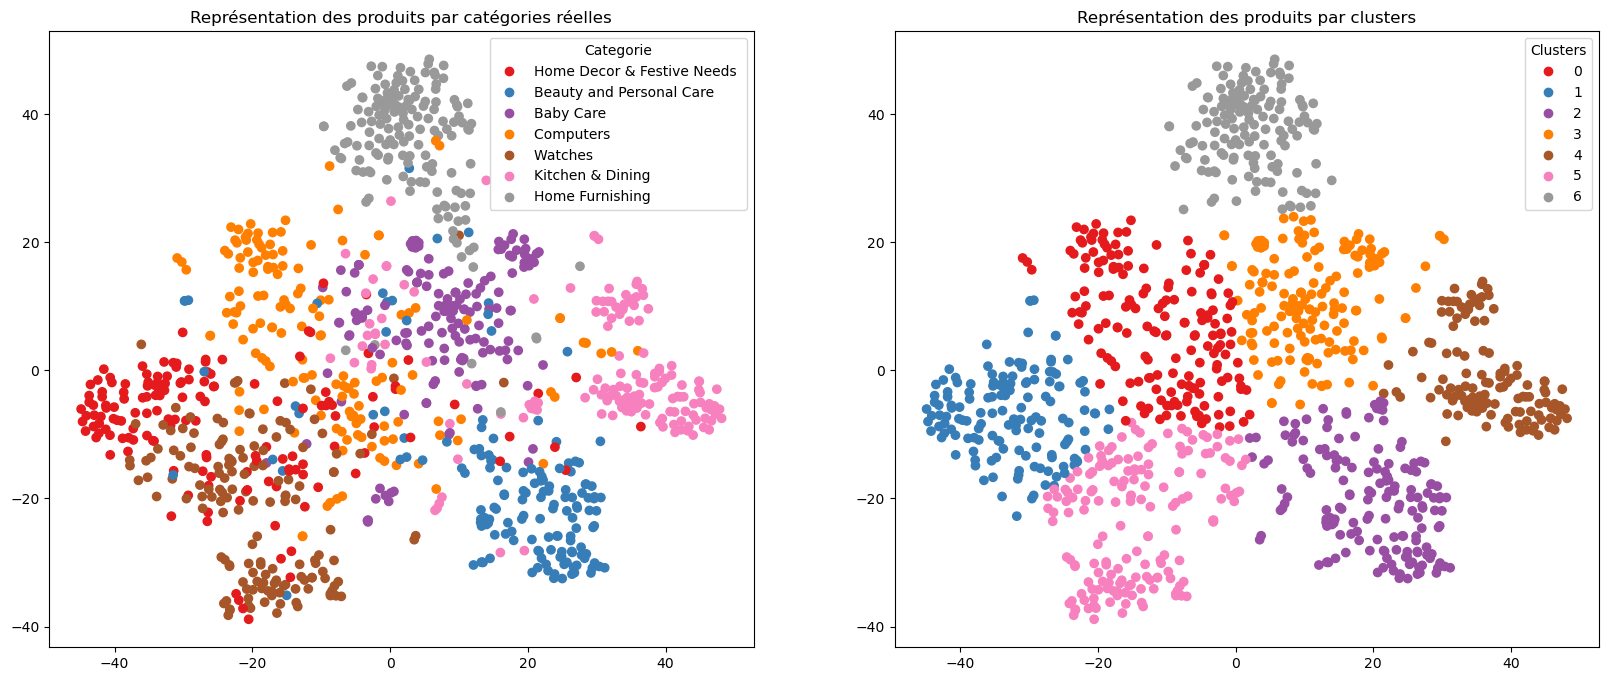

In [44]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG19", "TSNE", ARI]], axis=0)

ARI :  0.524


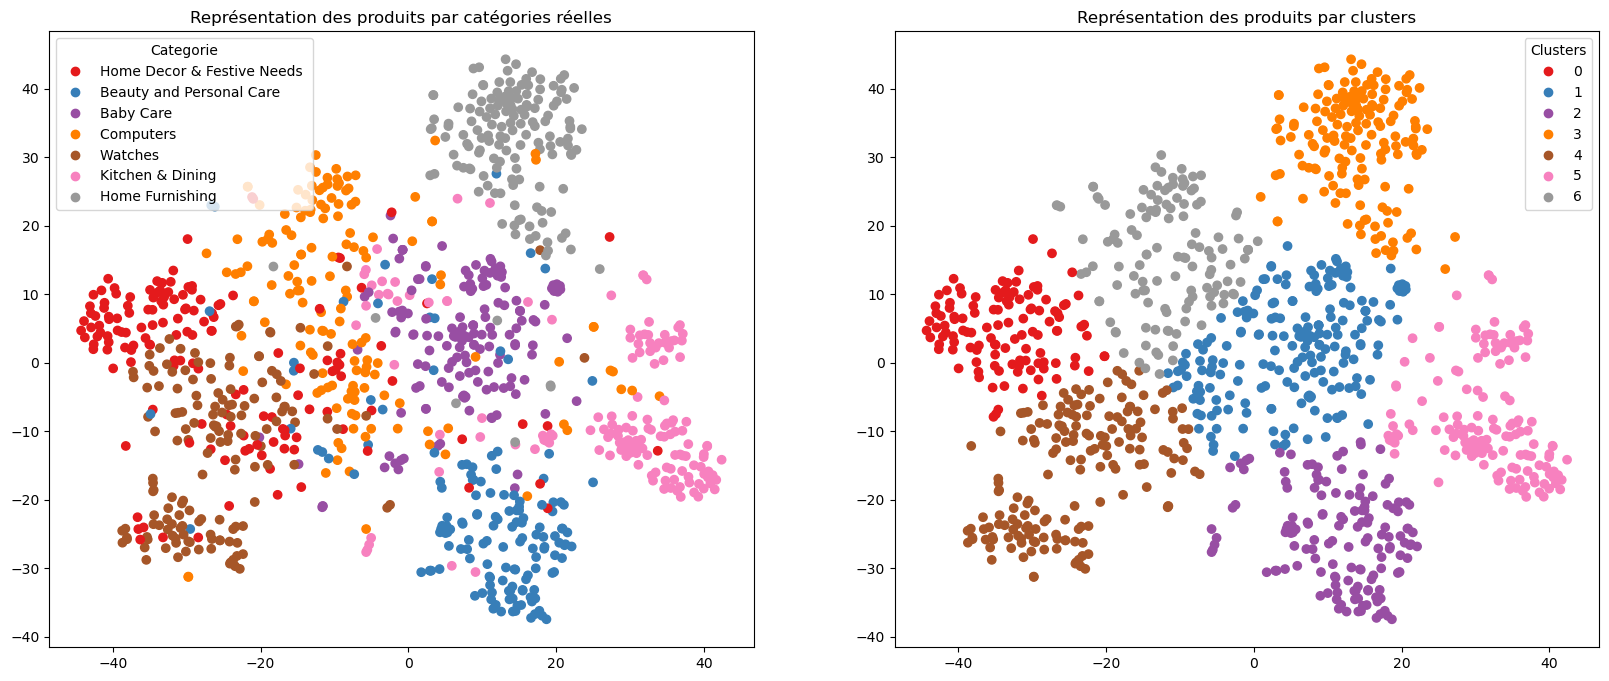

In [45]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["VGG19", "PCA-TSNE", ARI]], axis=0)

## <a name="C7"> 4) Xception</a>

In [47]:
# Présentation du modèle

from keras.applications import Xception

xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299, 3),
    pooling='avg'
)
xception_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 149, 149, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 149, 149, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 149, 149, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 147, 147, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 147, 147, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 147, 147, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 147, 147, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 147, 147, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 147, 147, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 74, 74, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 74, 74, 128)       │               

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [48]:
# Chargement des images et pre-processing spécifique
from keras.applications import xception

X = []

for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = xception.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:22<00:00, 45.96it/s]


In [49]:
from keras.applications import Xception
from keras.models import Model

# Charger le modèle Xception pré-entraîné
xception_model = Xception()

# Modifier le modèle pour obtenir la sortie de la couche avant la dernière
xception_model = Model(inputs=xception_model.input, outputs=xception_model.layers[-2].output)

# Prédiction sur les données X
features = xception_model.predict(X, batch_size=32, verbose=1)  


33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step


In [50]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["Xception", "None", ARI]], axis=0)

ARI :  0.4654


In [51]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["Xception", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 759
ARI :  0.4689


ARI :  0.5242


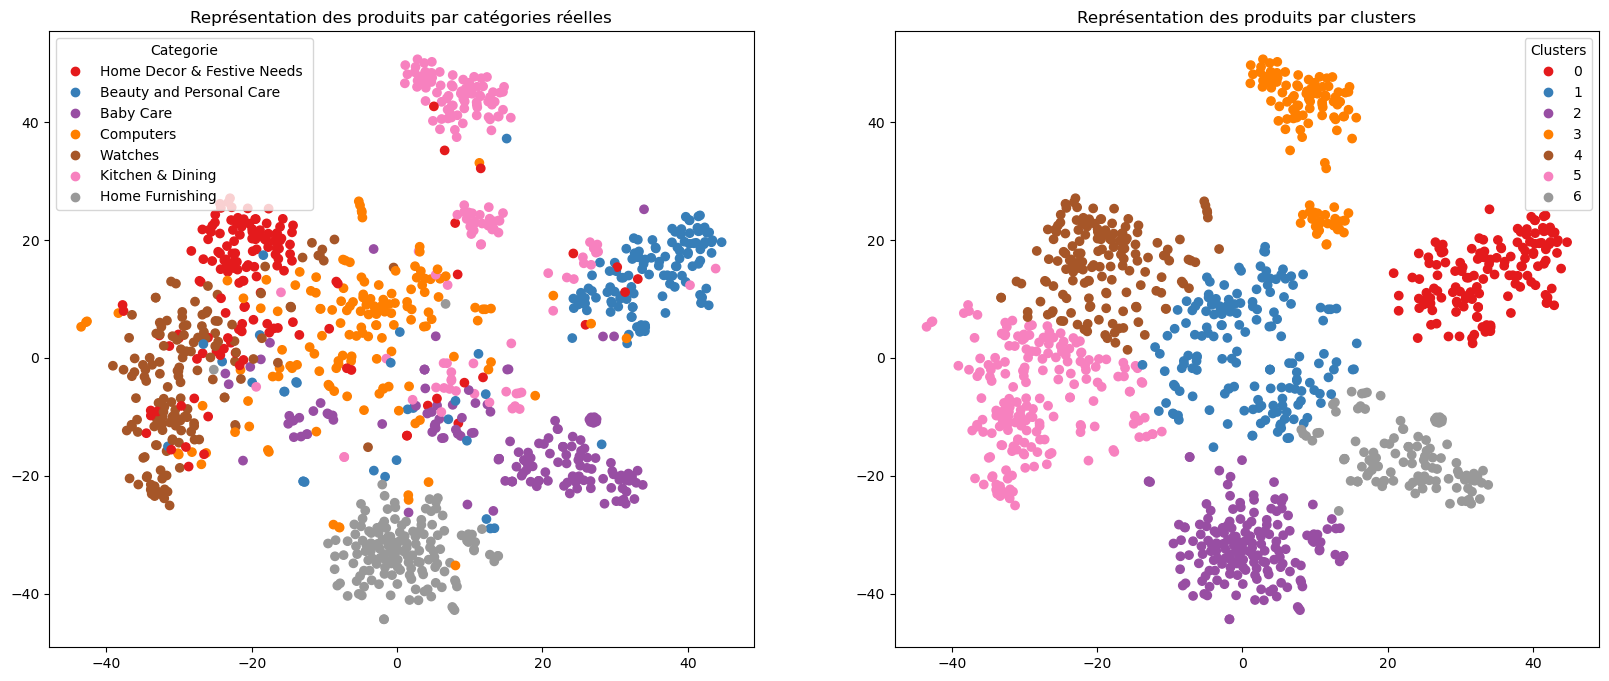

In [52]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["Xception", "TSNE", ARI]], axis=0)

ARI :  0.4961


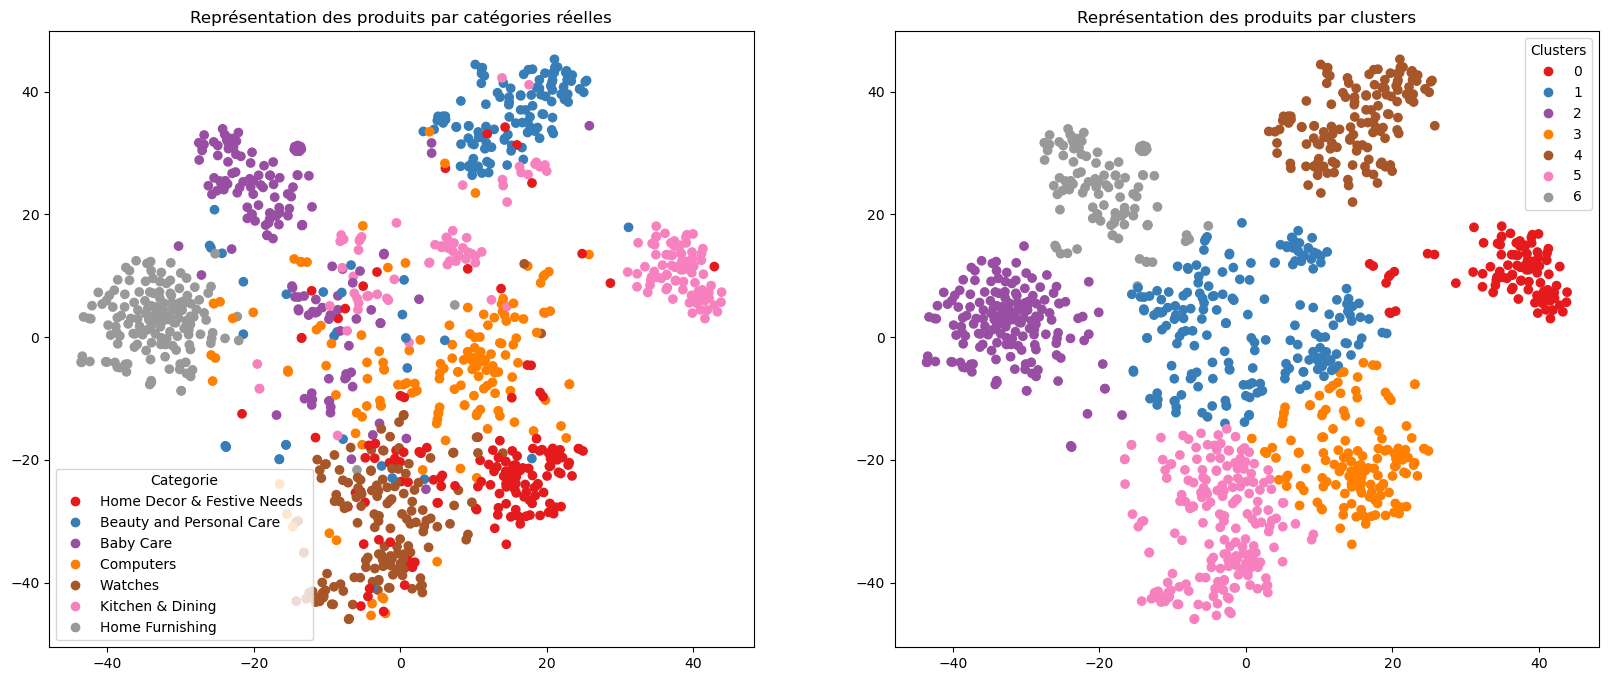

In [53]:
# PCA + TSNE + kmeans
X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["Xception", "PCA-TSNE", ARI]], axis=0)

## <a name="C8"> 5) Inception v3</a>

In [55]:
# Présentation du modèle

from keras.applications import InceptionV3

model_incep = InceptionV3(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg'
)
model_incep.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 149, 149, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 149, 149, 32)      │              96 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 147, 147, 32)      │              96 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 147, 147, 64)      │             192 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 73, 73, 80)        │             240 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 17, 17, 160)  480        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_59[0][0]'] 
          

                                                                                                  
 batch_normalization_69 (BatchN  (None, 17, 17, 192)  576        ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_78 (BatchN  (None, 17, 17, 192)  576        ['conv2d_78[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_80 (BatchN  (None, 8, 8, 320)   960         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_87[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_96[0][0]'] 
                                                                                                  
 batch_normalization_97 (BatchN  (None, 8, 8, 192)   576         ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_89[0][0]'] 
                                                                                                  
 mixed9_1 

In [56]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from PIL import ImageOps

# Charger le modèle InceptionV3 pré-entraîné
model_incep = InceptionV3(weights="imagenet")

# Modifier le modèle pour obtenir la sortie de la couche avant la dernière
model_incep = Model(inputs=model_incep.input, outputs=model_incep.layers[-2].output)

X = []

for image_num in tqdm(range(len(list_photos))):
    # Charger l'image et la convertir au bon format
    img = load_img(path + df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img)  # Égalisation de l'histogramme
    img = np.array(img).astype(np.float32)  # Convertir en tableau NumPy
    
    imgx = preprocess_input(img)  # Prétraitement pour InceptionV3
    X.append(imgx)

# Conversion en tableau NumPy
X = np.array(X)

# Prédiction des features
features = model_incep.predict(X, batch_size=32, verbose=1)  


100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:22<00:00, 46.59it/s]


33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


In [57]:
# kmeans
ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["InceptionV3", "None", ARI]], axis=0)

ARI :  0.4294


In [58]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["InceptionV3", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 704
ARI :  0.4361


ARI :  0.5476


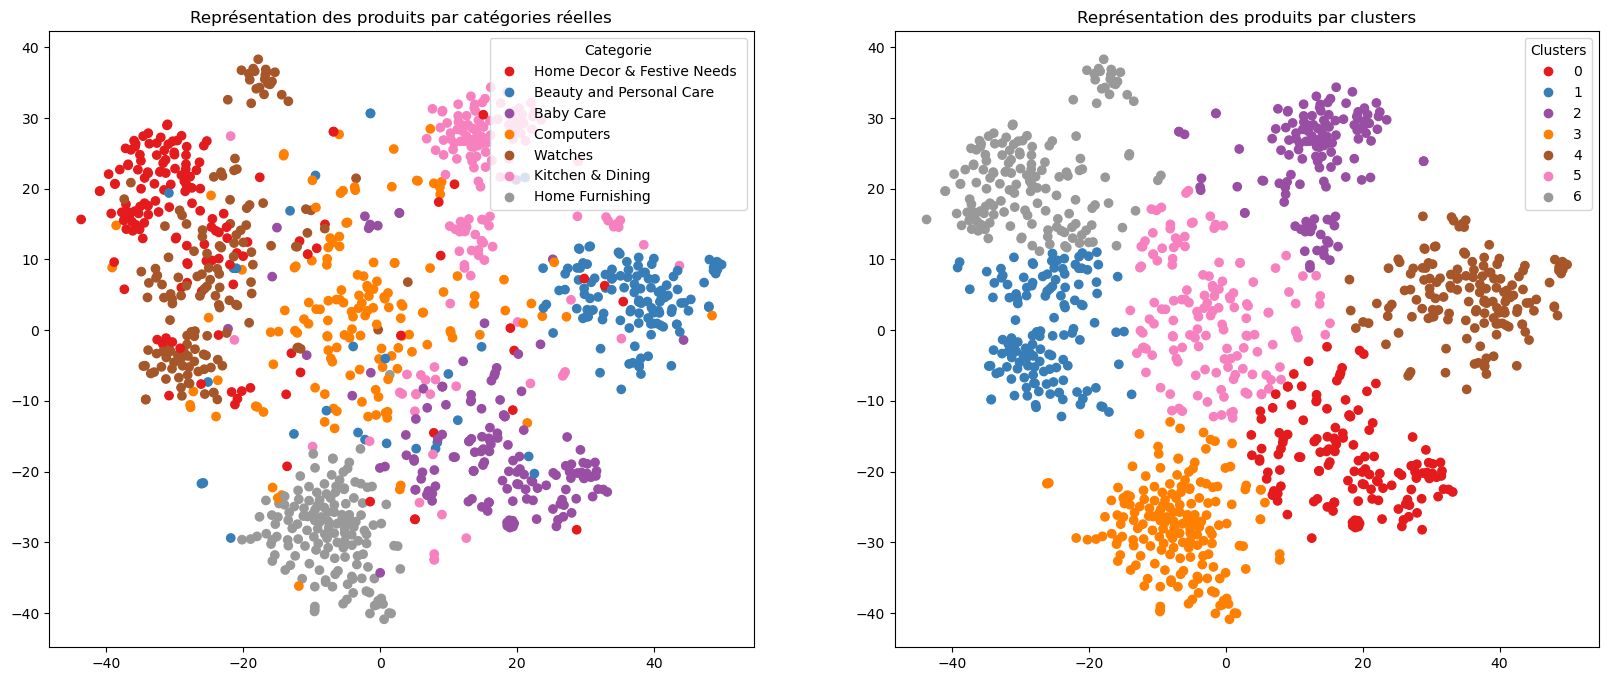

In [59]:
# TSNE + kmeans

X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["InceptionV3", "TSNE", ARI]], axis=0)

ARI :  0.5389


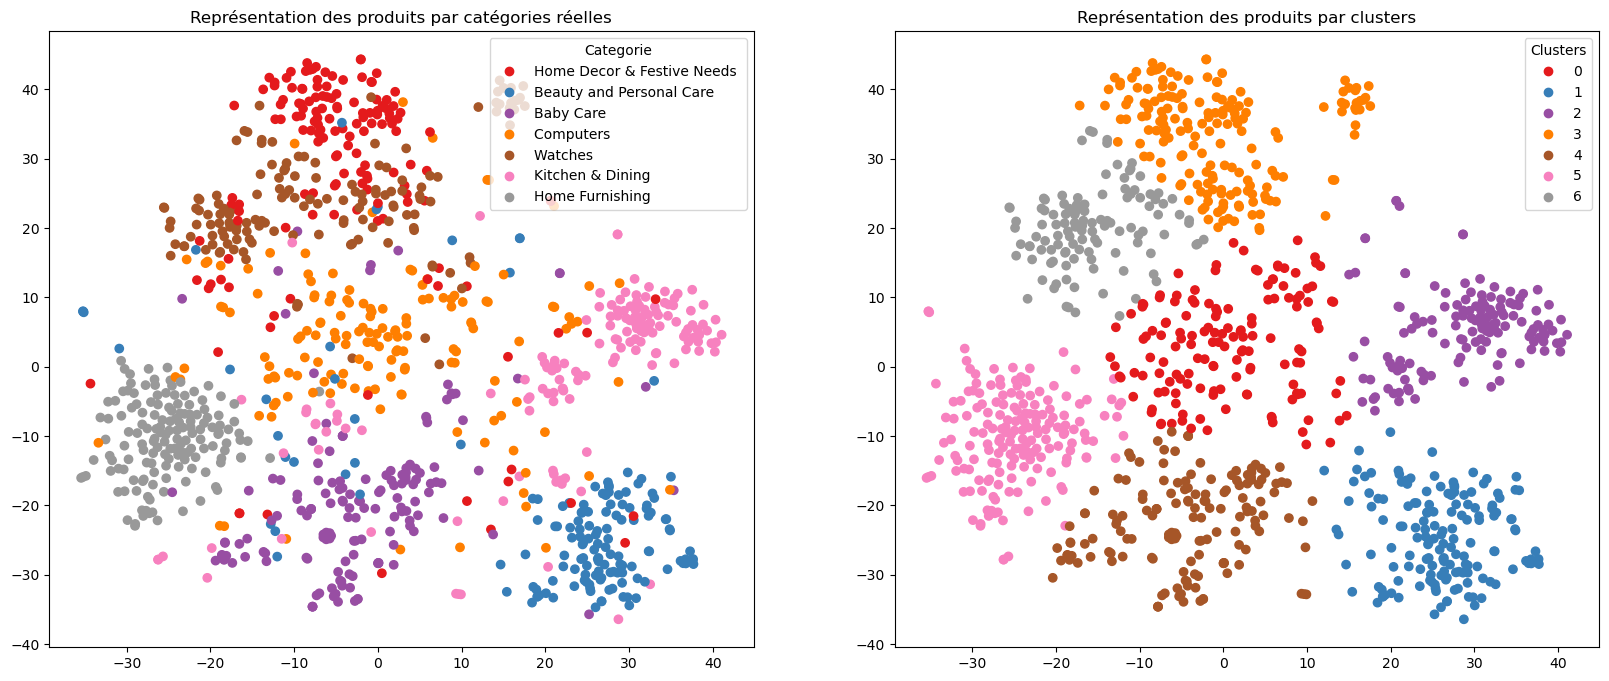

In [60]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(
    ARI_results, [["InceptionV3", "PCA-TSNE", ARI]], axis=0)

## <a name="C9"> 6) ResNet</a>

In [62]:
# Présentation du modèle

from keras.applications import ResNet50

ResNet_model = ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg'
)
ResNet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [63]:
# Chargement des images et pre-processing spécifique

from keras.applications import resnet


X = []
for image_num in tqdm(range(len(list_photos))):
    # try to extract the features and update the dictionary
    img = load_img(path+df["image"][image_num], target_size=(224, 224))
    img = ImageOps.equalize(img, mask=None)
    img = np.array(img)
    reshaped_img = img.reshape(224, 224, 3)
    imgx = resnet.preprocess_input(reshaped_img)
    X.append(imgx)


X = np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:21<00:00, 48.20it/s]


In [64]:
# Génération des features
features = ResNet_model.predict(X, batch_size=32, verbose=1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


In [65]:
# kmeans

ARI, labels = kmeans_fct(features, df['Categ_A'])

ARI_results = np.append(ARI_results, [["ResNet", "None", ARI]], axis=0)

ARI :  0.4012


In [66]:
# PCA + kmeans

pca = PCA(n_components=.99, random_state=22)
pca.fit(features)
x = pca.transform(features)

print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {pca.n_components_}")

ARI, labels = kmeans_fct(x, df['Categ_A'])

ARI_results = np.append(ARI_results, [["ResNet", "PCA", ARI]], axis=0)

Components before PCA: 2048
Components after PCA: 731
ARI :  0.4022


ARI :  0.508


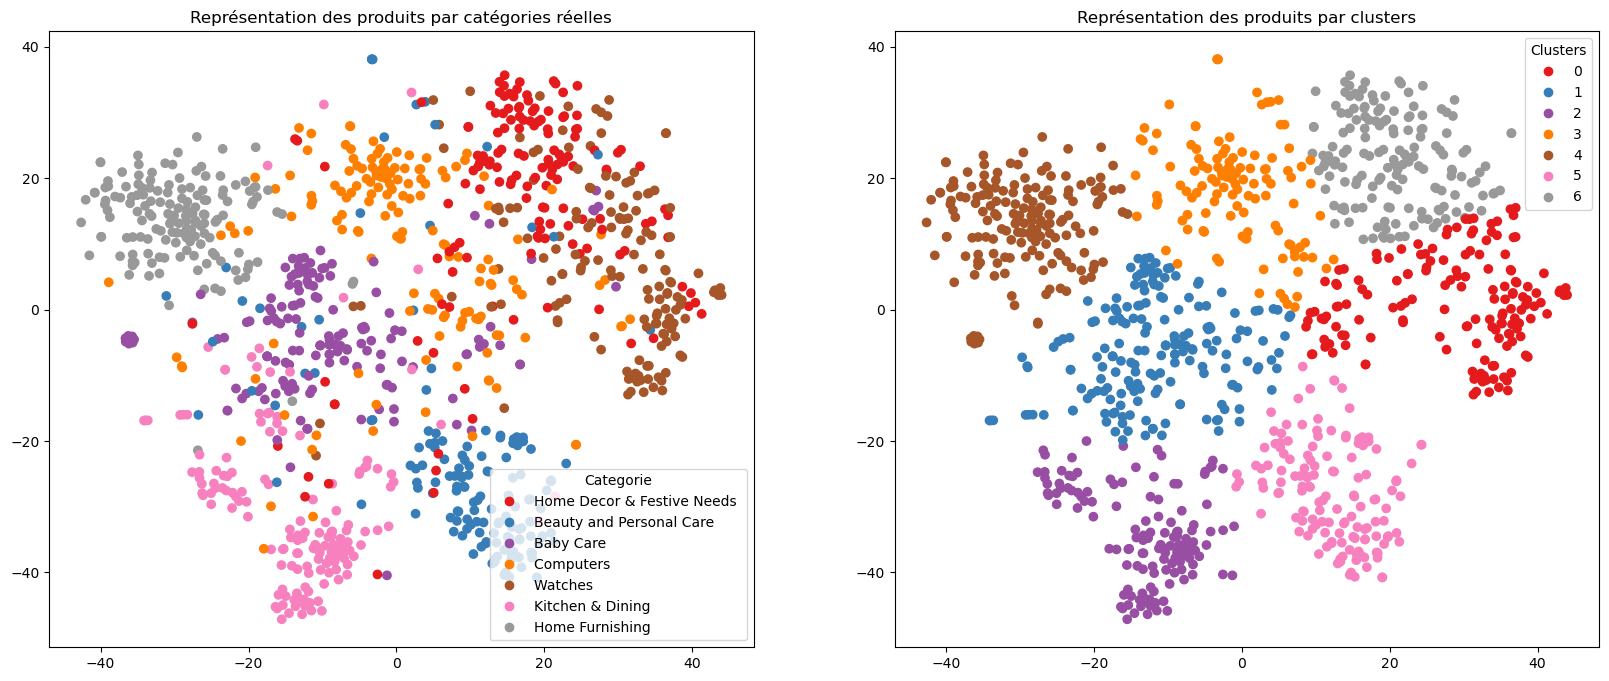

In [67]:
# TSNE + kmeans
X_reduc = reduction_fct(features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["ResNet", "TSNE", ARI]], axis=0)

ARI :  0.5098


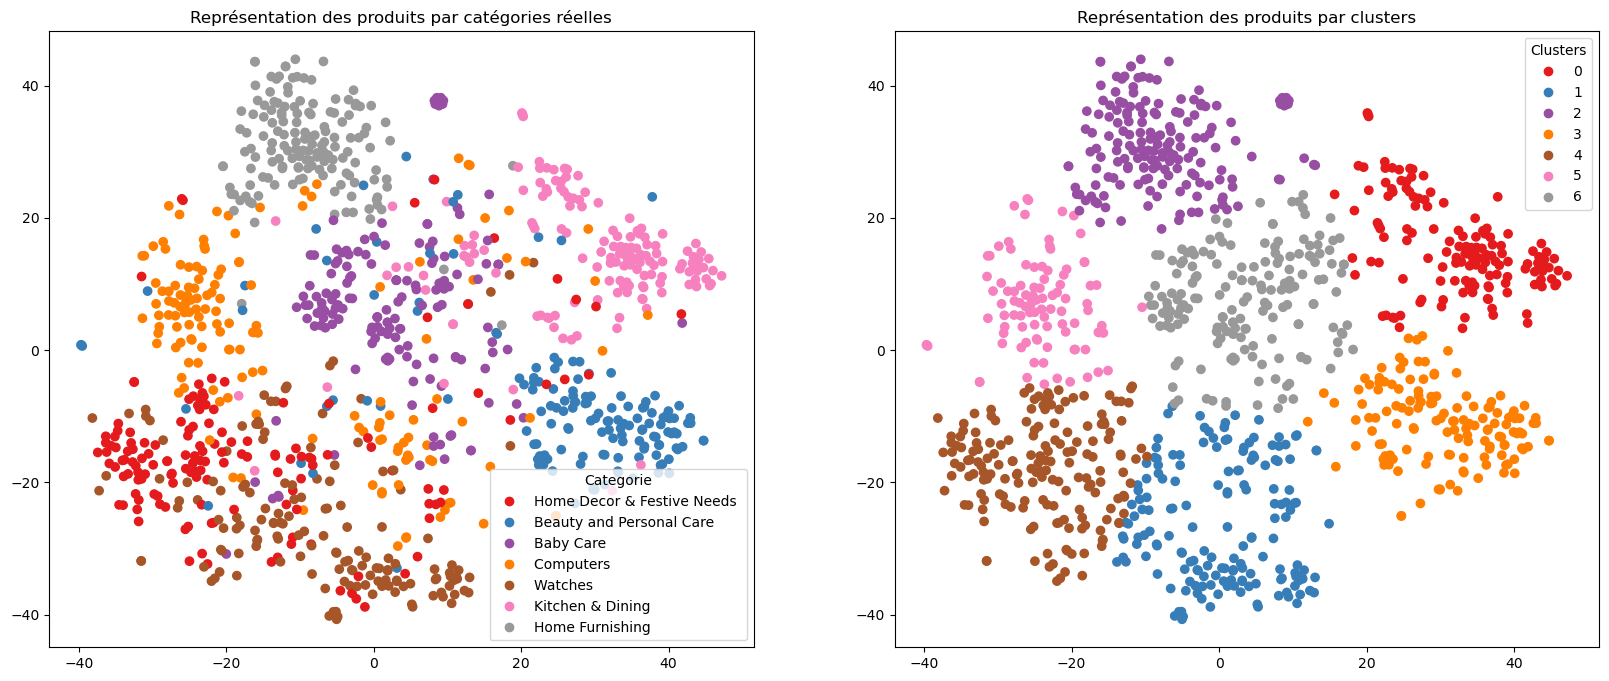

In [68]:
# PCA + TSNE + kmeans

X_reduc = reduction_fct(x, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])
reduc_visu_fct(X_reduc, df['Categ_A'], labels)

ARI_results = np.append(ARI_results, [["ResNet", "PCA-TSNE", ARI]], axis=0)

# <a name="C10"> IV) Analyse du meilleur modèle</a>

In [70]:
# Génération du DF de l'ARI
ARI_results_df = pd.DataFrame(
    ARI_results, columns=["model", "reduction", "ARI"])
ARI_results_df['ARI'] = ARI_results_df['ARI'].astype(float)

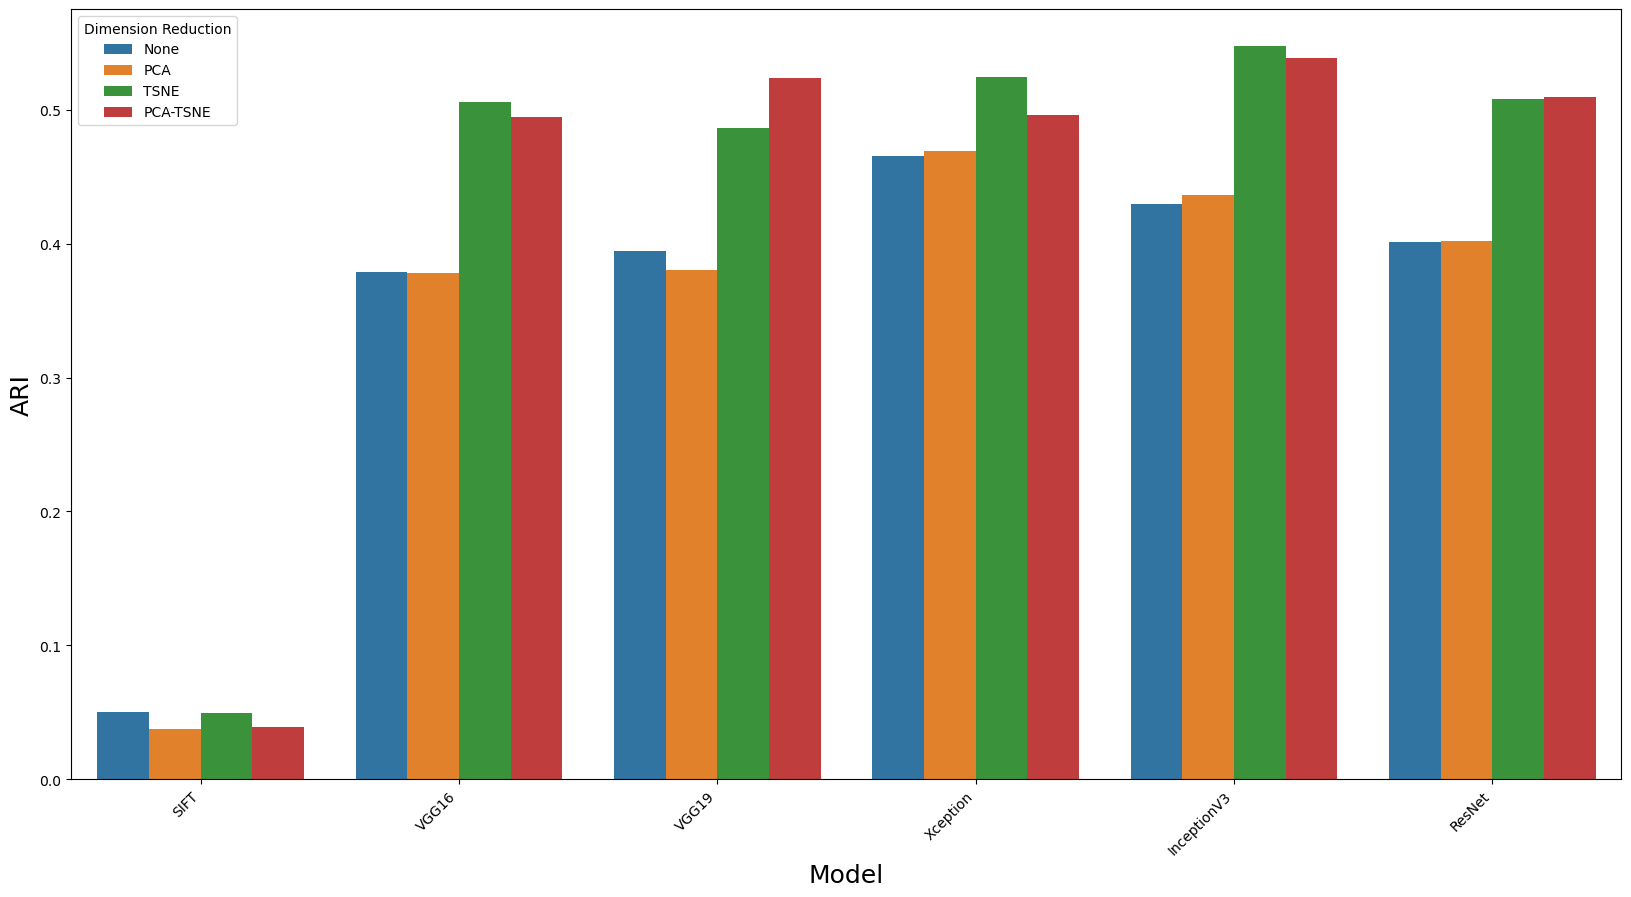

In [71]:
# Représentation graphique

plt.figure(figsize=(20, 10))

sns.barplot(data=ARI_results_df, x="model", y="ARI", hue="reduction")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dimension Reduction')
plt.xlabel('Model', fontsize=18)
plt.ylabel('ARI', fontsize=18)

plt.show()

In [72]:
# Recréation des features du meilleur modèle
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from PIL import ImageOps

model_incep = InceptionV3(weights="imagenet")

model_incep = Model(inputs=model_incep.input, outputs=model_incep.layers[-2].output)

X = []

for image_num in tqdm(range(len(list_photos))):
    # Charger l'image et la convertir au bon format
    img = load_img(path + df["image"][image_num], target_size=(299, 299))
    img = ImageOps.equalize(img)  # Égalisation de l'histogramme
    img = np.array(img).astype(np.float32)  # Convertir en tableau NumPy
    
    imgx = preprocess_input(img)  # Prétraitement pour InceptionV3
    X.append(imgx)

# Conversion en tableau NumPy
X = np.array(X)

# Prédiction des features
features = model_incep.predict(X, batch_size=32, verbose=1)  # Suppression de `use_multiprocessing`

# Réduction de dimension
X_reduc = reduction_fct(features, reduc='TSNE')

# Clustering avec K-Means
ARI, labels = kmeans_fct(X_reduc, df['Categ_A'])


100%|██████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:21<00:00, 49.62it/s]


33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
ARI :  0.5476


In [73]:
# Encodage des catégories

LE = LabelEncoder()
y_categ = LE.fit_transform(df['Categ_A'])

In [74]:
# Matrice de confusion

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_categ, labels)

In [75]:
cm

array([[  4,  28,   5,   4,   4,   8,  97],
       [  8,   3,   3,   8, 122,   3,   3],
       [126,   2,   3,   5,   3,  10,   1],
       [  1,  14,  12,   8,   8, 102,   5],
       [  0,  89,   1,   0,   0,  11,  49],
       [  7,   1, 109,   6,  15,  11,   1],
       [  0,   0,   0, 149,   0,   1,   0]], dtype=int64)

In [76]:
# réarrangement des clusters pour plus de visibilité (par l'algorithme Hungarian)

from scipy.optimize import linear_sum_assignment as linear_assignment


def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)


indexes = linear_assignment(_make_cost_m(cm))
indexes = np.array(list(zip(*indexes)))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

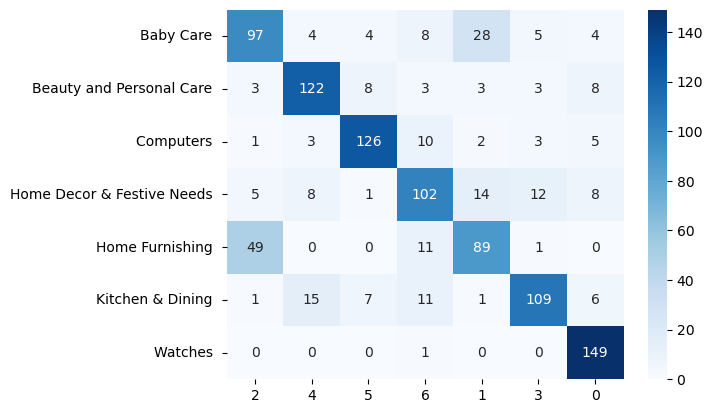

In [77]:
# représentation graphique

df_cm = pd.DataFrame(cm2, index=[label for label in list(np.unique(df["Categ_A"]))],
                     columns=[i for i in list(np.argmax(cm, axis=0))])
ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")